In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import os,sys,glob,natsort
import pandas as pd
import scipy.io
import ipywidgets 
import h5py
import scipy.stats
import pickle
import tqdm
import warnings
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import os,sys,glob,natsort

class TQDMBytesReader(object):

    def __init__(self, fd, **kwargs):
        self.fd = fd
        from tqdm import tqdm
        self.tqdm = tqdm(**kwargs)

    def read(self, size=-1):
        bytes = self.fd.read(size)
        self.tqdm.update(len(bytes))
        return bytes

    def readline(self):
        bytes = self.fd.readline()
        self.tqdm.update(len(bytes))
        return bytes

    def __enter__(self):
        self.tqdm.__enter__()
        return self

    def __exit__(self, *args, **kwargs):
        return self.tqdm.__exit__(*args, **kwargs)
    
def load_mat(data_path):
    f = h5py.File(data_path)
    obj = dict(h5py_obj=f)
    print("Loading Calculated Edge Data")
    obj['edges'] = np.array(f['edges'])
    print("Loading Raw Video Data [this takes some time...]")
    obj['data']  = np.array(f['data_prime'])
    aspect_ratio = obj['data'].shape[1:][::-1]
    obj['ar'] = np.array(aspect_ratio)
    return obj

def load_pickle(data_path):
    total = os.path.getsize(data_path)
    with open(data_path, 'rb') as fh:
        with TQDMBytesReader(fh, total=total) as pklfh:
            up = pickle.Unpickler(pklfh)
            obj = up.load()
#        obj = pickle.load(fh)
    return obj  

def mypltter(dfrow):
    path = dfrow.path
    Q = np.load(path)
    Qar = np.array(Q.shape[::-1])/100
    plt.figure(figsize=Qar)
    plt.imshow(Q/(2**16-1)*255.,cmap=plt.cm.Greys_r,origin='lower') # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    plt.title(f"Path: {path}, idx: {dfrow.inds}",fontsize=24)
    plt.xlabel("Width",fontsize=20)
    plt.ylabel("Height",fontsize=20)
    ax = plt.gca()
    pcolor,lcolor = '#0f0', '#ff0'
    if 'preds' in dfrow: 
        if dfrow.preds != dfrow.label:
            pcolor = '#f00'
            lcolor = '#0ff'
        ax.text(
            0.90, 
            0.1, 
            f'P: {dfrow.preds_str}', 
            size=32, 
            color=pcolor,
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes
        )
    ax.text(
        0.96, 
        0.1, 
        f'L: {dfrow.label_str}', 
        size=32, 
        color=lcolor,
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes
    )
    ax.text(
        0.04, 
        0.1, 
        f'R: {dfrow.regime_str}', 
        size=32, 
        color='#ff0',
        horizontalalignment='center',
        verticalalignment='center', 
        transform=ax.transAxes
    )
    #plt.savefig(f'{figd}/t{time_index:04d}.png',bbox_inches='tight',dpi=100)
def sector_cut(df,num_sectors=32):
    with pd.option_context('mode.chained_assignment', None):
        mp1,mp2 = df[['p1','p2']].mean()
        df.loc[:,'pp1'],df.loc[:,'pp2'] = df['p1']-mp1,df['p2']-mp2
        df.loc[:,'r2'] = df['pp1']**2 + df['pp2']**2
        rmax = np.sqrt(df['r2'].max())
        df['np1'],df['np2'] = df['pp1']/rmax,df['pp2']/rmax
        df['nr'] = np.sqrt(df.np1**2+df.np2**2)
        df['theta']= np.arctan2(df['pp1'],df['pp2'])
        df['sector'] = pd.cut(df.theta,np.linspace(-1,1,num_sectors+1)*np.pi,labels=np.arange(num_sectors))
        df = df.sort_values(by='theta')

#       Qdf = df.loc[df.groupby('sector')['nr'].idxmax()]
        Qdf = df.loc[
            df.groupby('sector').apply(
                lambda x: x['nr'].idxmax()
                if len(x)
                else np.nan
            ).dropna()
        ]
        return Qdf

def plt_sector(df,sdf):
    N = num_sectors = len(sdf)
    M = N - 1
    plt.figure(figsize=(6,6))
    t = np.linspace(0,1,1001)*np.pi*2
    u = np.exp(-1j*t)
    plt.plot(u.real,u.imag,'k-',lw=3)
    for k in range(N):
        sector = df[df['sector']==k] # full sector
        plt.plot(sector['np1'],sector['np2'],'o',ms=1,c=plt.cm.rainbow(k/M))
        _t =  -np.pi+k*2*np.pi/N
        _x,_y = np.r_[np.cos(_t),np.sin(_t)]
        plt.plot(np.r_[0,_x],np.r_[0,_y],'k-',zorder=100,alpha=0.3)
        _t +=  np.pi/N
        _x,_y = 1.08*np.r_[np.cos(_t),np.sin(_t)]
        plt.annotate(f'{k}',(_x,_y),ha='center',va='center',weight=500,fontsize=5)
        try:
            ind = sector['r2'].argmax()
            sector_x = sector['np1'].iloc[ind]
            sector_y = sector['np2'].iloc[ind]
            plt.plot(sector_x,sector_y,'o',ms=5,mec='none',c=plt.cm.rainbow(k/(N-1)))
        except Exception as ex:
            print('exception occured, likely empty sector: ', ex)
        
    plt.axis('equal')
    plt.plot(sdf.np1,sdf.np2,'o',ms=5,mec='k',mfc='none')
    
    
    plt.annotate(df.label_str.iloc[0],(1.0,1.0),weight=700,ha='center',va='center',color='#080',fontsize=14)
    
    ## quarter fun
    # plt.plot(u.real/4,u.imag/4,'b-',lw=2)
    # BG = G[G.nr<=0.25]
    # Q = BG.loc[BG.groupby('sector')['r2'].idxmax()]
    # plt.plot(Q.np1,Q.np2,'o',ms=5,mec='b',mfc='none')
    
    ## turn off axis (LAST)
    plt.axis('off')
#   plt.savefig('sector-sanity.png',bbox_inches='tight')

pio.renderers.default = 'iframe'
pdf = pd.read_csv('/home/jlbuzins/research/pca-metadata-X-dropped.csv')
pdf['inds']=pdf.index
edf = pd.read_pickle('/home/jlbuzins/research/CNN-variants/error_test_df_modelhh.pkl')
edf['inds']=edf.index
label_lookup = 'LBOUG'
edf['preds_str']=edf.apply(lambda x: label_lookup[x.preds],axis=1)
edf['experiment']=edf.apply(lambda x: '/'.join(x.path.split('/')[-3:]),axis=1)
pdf['experiment']=pdf.apply(lambda x: '/'.join(x.path.split('/')[-3:]),axis=1)

In [2]:
base_dir      = '/data/sse/projects/Cambridge-IDE/dropbox'
base_sdir     = '/scratch/jlbuzins'
base_mat_data_dir = f'{base_dir}/Matlab cleaned up movies + edges + data'
base_data_dir = f'{base_sdir}/data'

state_info_path = f'{base_dir}/Regime diagrams 2013-2022.xlsx'

data_paths = natsort.realsorted(glob.glob(f'{base_data_dir}/theta*/*.pkl'))
df = pd.read_excel(state_info_path,skiprows=6)


# Select an Experiment to Visualize

Use the dropdown below to select an experiment to analyze!

In [3]:
data_paths_drop = []
for i in data_paths:
    k = i.split('/')[-2] + ('/') + i.split('/')[-1]
    data_paths_drop.append(k)

In [4]:
data_paths_dropdown = ipywidgets.Dropdown(options=data_paths_drop,value=data_paths_drop[0],description="Analyze:")
data_paths_dropdown

Dropdown(description='Analyze:', options=('theta1degree/exp_w031.pkl', 'theta1degree/exp_w032.pkl', 'theta1deg…

In [5]:
data_path = data_paths_dropdown.value
data_path = f'{base_data_dir}/{data_path}'
experiment_id = xid = data_path.split('/')[-1].split('_')[1].split('.')[0]
time_between_frames = dt = float(df.set_index('Exp').loc[xid,'Frame sep'])*10

if time_between_frames != time_between_frames:
    print(f"\x1b[1;31mERROR -- time_between_frames (dt) is not a number!!!\x1b[0m")
print(df.set_index('Exp').loc[xid])
print(f"Selected data path: \x1b[1;32m\"{data_path}\"\x1b[0m\nSelected pickle file: \x1b[1;34m\"{data_path.split('/')[-1]}\"\x1b[0m")
print(f"\x1b[1;30mExperiment ID\x1b[1;0m: {xid}")
print(f"\x1b[1;30mComments\x1b[1;0m\n", df.set_index('Exp').loc[xid,'Comments'])
print(f"\x1b[1;30mFurther Comments\x1b[1;0m\n", df.set_index('Exp').loc[xid,'Further Comments '])
print(f"\x1b[1;30mTime between frames (dt)\x1b[1;0m: {dt} seconds")

Date                                                                          2022-01-24 00:00:00
Who                                                                                            AL
θ (deg.)                                                                                        1
ρ_L                                                                                      1.086144
ρ_R                                                                                      1.047417
Δρ / ρ_0                                                                                 0.036303
Re^h                                                                                  3177.163824
Regime classification on the day of the expt                                                    I
Comments                                                                                      NaN
Unnamed: 10                                                                                   NaN
Regime (by AL)      

In [24]:
%%time
print("Loading data... [this can take up to ~10 seconds]")
obj = load_pickle(data_path)
LT,LZ,LX = obj['data'].shape
print(f"Number of timesteps: {LT}")
print(f"       pixel width: {LX}")
print(f"       pixel height: {LZ}")

Loading data... [this can take up to ~10 seconds]


100%|█| 3767729239/3767729239 [00:09<00:00, 402068555.54it/s]

Number of timesteps: 400
       pixel width: 3319
       pixel height: 473
CPU times: user 163 ms, sys: 2.48 s, total: 2.64 s
Wall time: 9.49 s


# Observe the evolution of the experiment's flow below!
Move the time index slider to see how the flow changes over time.

In [6]:
def interactive_plot(time_index):
    plt.figure(figsize=obj["ar"]/100)
    plt.imshow(obj["data"][time_index],cmap=plt.cm.Greys_r,origin='lower') # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    plt.title(f"Experiment: {experiment_id}\nFlow at time index: {time_index} of {LT-1}",fontsize=24)
    plt.xlabel("Width",fontsize=20)
    plt.ylabel("Height",fontsize=20)
ipywidgets.interact(interactive_plot,time_index=ipywidgets.IntSlider(min=0, max=LT-1, step=1, value=0, description="Time Index:"))
None

NameError: name 'LT' is not defined

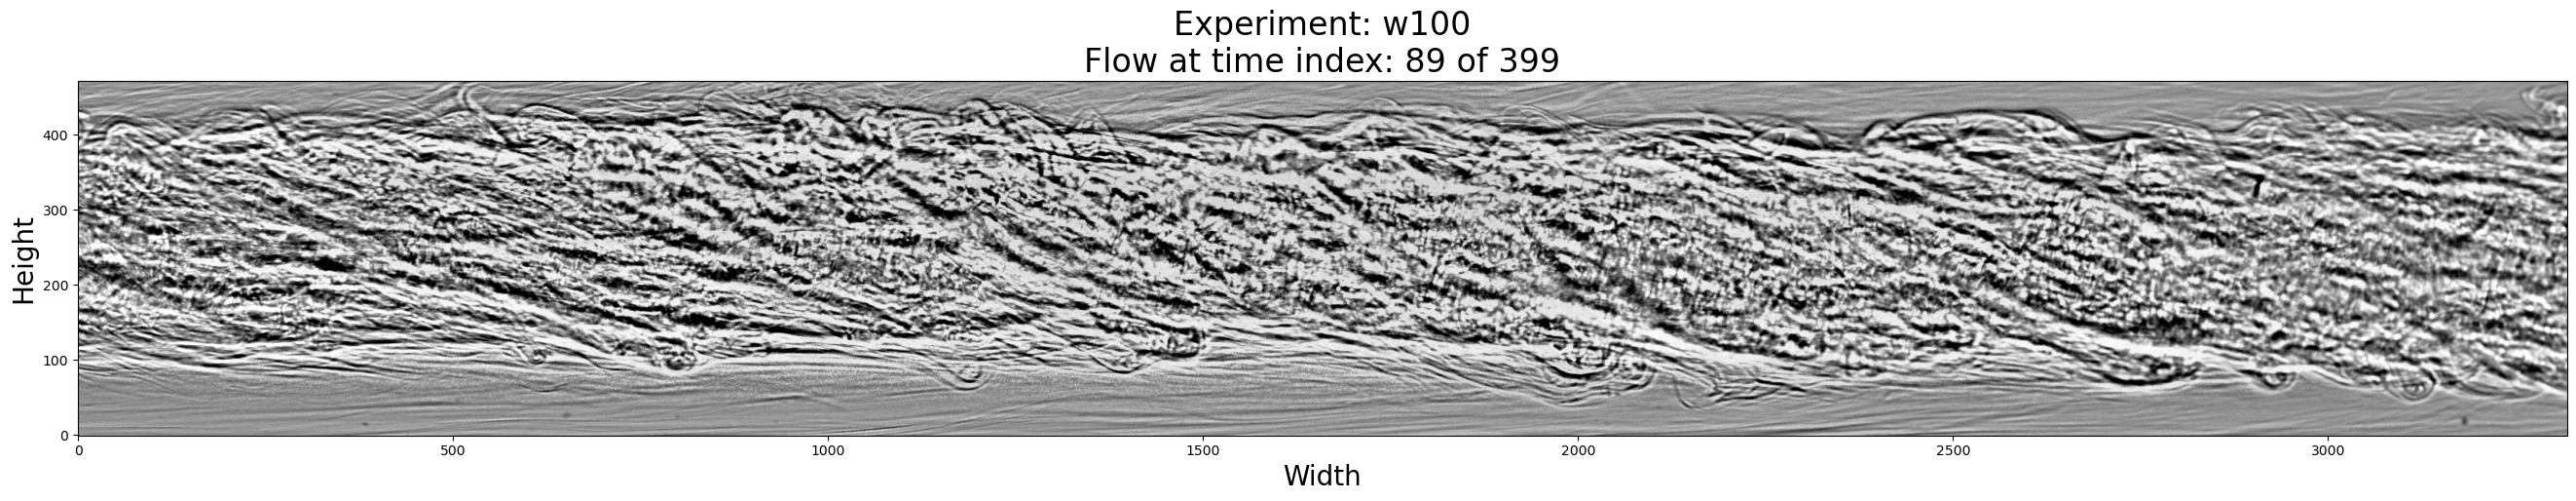

In [26]:
time_index =89
plt.figure(figsize=obj["ar"]/100)
plt.imshow(obj["data"][time_index]/(2**16-1)*255.,cmap=plt.cm.Greys_r,origin='lower') # https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title(f"Experiment: {experiment_id}\nFlow at time index: {time_index} of {LT-1}",fontsize=24)
plt.xlabel("Width",fontsize=20)
plt.ylabel("Height",fontsize=20)
plt.savefig('w100_t91.png',bbox_inches='tight',dpi=100)
None

# How are flow frames categorized differently by Pricipal Component Analysis and a Convolutional Neural Net?
Below, the frames are plotted in the PCA space. Each color indicates a cluster; points that are colored differently from their cluster have been misclassified by the CNN.  

In [106]:
custom_data=np.stack((edf.p1,edf.p2,edf.label_str,edf.preds_str,edf.regime_str,edf.inds,edf.experiment),axis=-1)
hover_template='''
<b>p1</b>: %{customdata[0]}
<br>
<b>p2</b>: %{customdata[1]}
<br>
<b>label_str</b>: %{customdata[2]}
<br>
<b>preds_str</b>: %{customdata[3]}
<br>
<b>regime_str</b>: %{customdata[4]}
<br>
<b>index</b>: %{customdata[5]}
<br>
<b>exp.</b>: %{customdata[6]}
'''
my_colors=[
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
]
my_colors=[ '#0ff', '#f80', '#0b0', '#f00', '#c0c' ]
Cpdf=[my_colors[ell] for ell in pdf.label]
Cedf=[my_colors[p] for p in edf.preds]

fig=px.scatter_3d(
    pdf,
    x='p1',
    y='p2',
    z='label',
    color='label_str',
    hover_data=list(pdf.drop(columns=['angle','frame','path']).columns),  
    color_discrete_map = {state:my_colors[k] for k,state in enumerate(label_lookup)},
)
fig.update_traces(
    marker=dict(
#        color=Cpdf,
        opacity=0.4,
        size=1,
        line=dict(
            width=0,
            color='black',
        ),
    ),
    selector=dict(mode='markers'),
)

fig=fig.add_trace(
    go.Scatter3d(
        x=edf.p1,
        y=edf.p2,
        z=edf.label,
        mode='markers',
        marker=dict(
            size=3,
            color=Cedf,
            line=dict(
                width=0.1,
                color='black',
            ),
        ),
        hovertemplate=hover_template,
        customdata=custom_data,
    )
)

fig.update_layout(
    width=1000,
    height=800,
    hoverlabel=dict(
        font=dict(
            family='monospace',
            size=10,
        ),
    ),
    legend=dict(
        
    ),
    legend_font=dict(color='#eee',size=24),
    legend_itemsizing='constant',
    legend_bgcolor='#444',
    paper_bgcolor='#222',
    plot_bgcolor='#333',
    scene = dict(
        xaxis = dict(
             backgroundcolor="#555",
             gridcolor="#eeeeee",
             showbackground=True,
             zerolinecolor="#eeeeee",),
        yaxis = dict(
            backgroundcolor="#333",
            gridcolor="#eeeeee",
            showbackground=True,
            zerolinecolor="#eeeeee"),
        zaxis = dict(
            backgroundcolor="rgba(0,0,0,0)",
            gridcolor="#eeeeee",
            showbackground=True,
            zerolinecolor="#eeeeee",
        ),
    ),
    font_color="#ff0",
)


fig.update_layout(paper_bgcolor="#222")

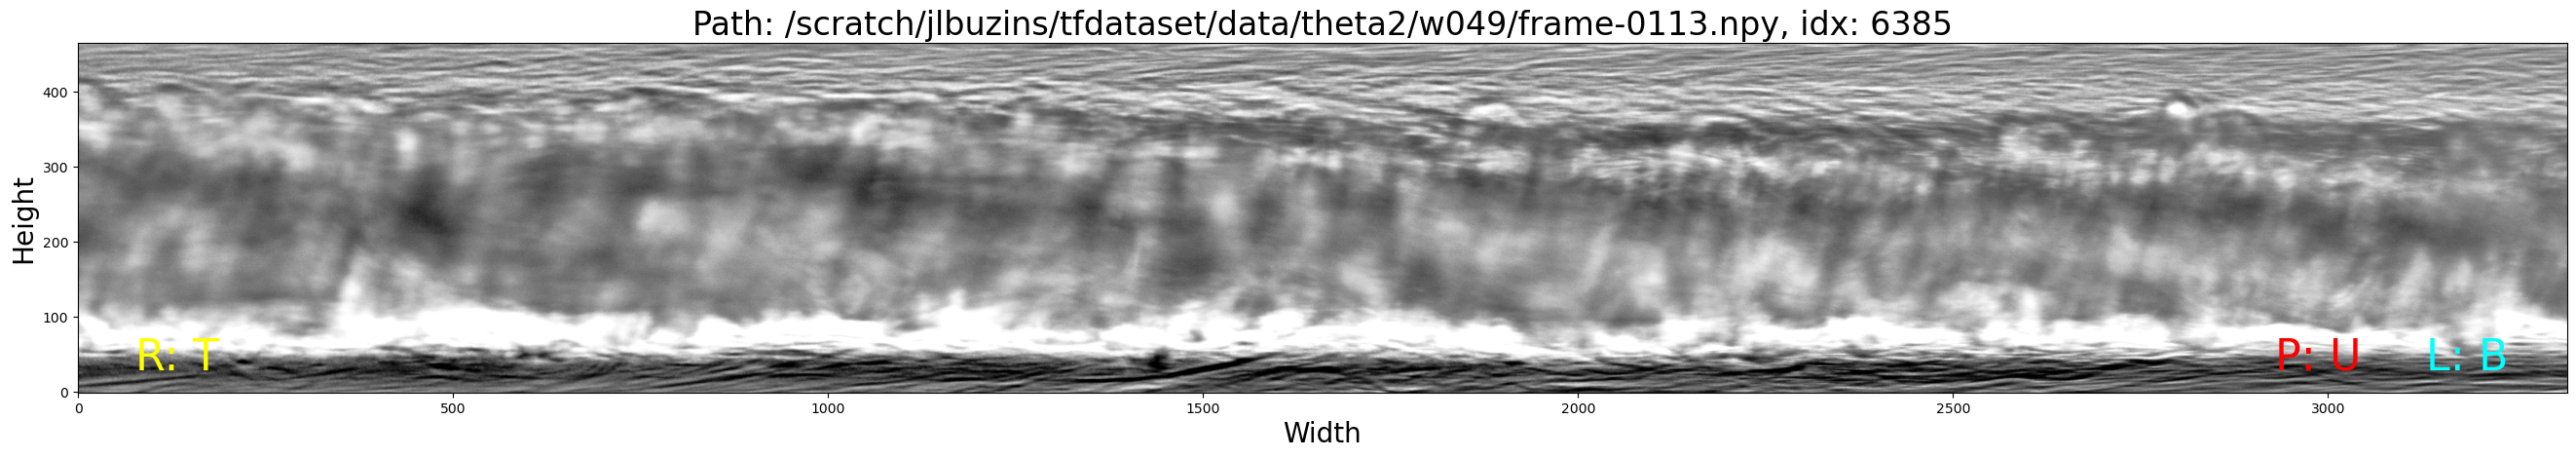

In [19]:
mypltter(edf.loc[6385])

In [18]:
pdf

angle                  experiment  frame label_str  label        p1  \
0          1  theta1/w031/frame-0067.npy     67         L      0  1.227888   
1          1  theta1/w031/frame-0068.npy     68         L      0  0.871172   
2          1  theta1/w031/frame-0069.npy     69         B      1  0.211218   
3          1  theta1/w031/frame-0070.npy     70         L      0  0.988475   
4          1  theta1/w031/frame-0071.npy     71         L      0  0.952921   
...      ...                         ...    ...       ...    ...       ...   
35323      6  theta6/w150/frame-0395.npy    395         L      0  3.970069   
35324      6  theta6/w150/frame-0396.npy    396         L      0  4.075031   
35325      6  theta6/w150/frame-0397.npy    397         L      0  4.183092   
35326      6  theta6/w150/frame-0398.npy    398         L      0  3.608835   
35327      6  theta6/w150/frame-0399.npy    399         L      0  3.649194   

             p2 regime_str                                               path  \
0     -0.317219          I  /scratch/jlbuzins/tfdataset/data/theta1/w031/f...   
1     -0.229325          I  /scratch/jlbuzins/tfdataset/data/theta1/w031/f...   
2     -0.036266          I  /scratch/jlbuzins/tfdataset/data/theta1/w031/f...   
3     -0.203494          I  /scratch/jlbuzins/tfdataset/data/theta1/w031/f...   
4     -0.267957          I  /scratch/jlbuzins/tfdataset/data/theta1/w031/f...   
...         ...        ...                                                ...   
35323  0.215481          H  /scratch/jlbuzins/tfdataset/data/theta6/w150/f...   
35324  0.392876          H  /scratch/jlbuzins/tfdataset/data/theta6/w150/f...   
35325  0.407834          H  /scratch/jlbuzins/tfdataset/data/theta6/w150/f...   
35326  0.037793          H  /scratch/jlbuzins/tfdataset/data/theta6/w150/f...   
35327  0.048867          H  /scratch/jlbuzins/tfdataset/data/theta6/w150/f...   

        inds  
0          0  
1          1  
2          2  
3          3  
4          4  
...      ...  
35323  35323  
35324  35324  
35325  35325  
35326  35326  
35327  35327  

[35328 rows x 10 columns]

# What if we train our CNN only with the edges of each cluster?

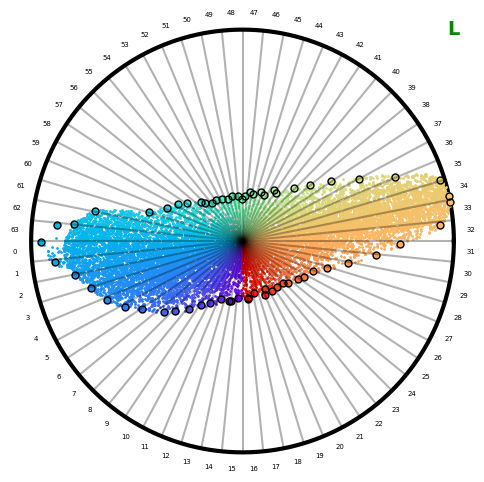

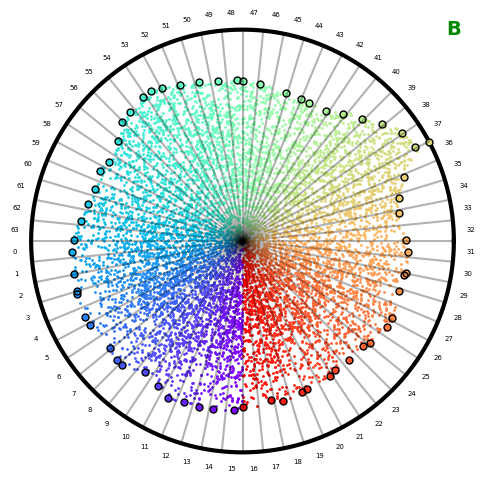

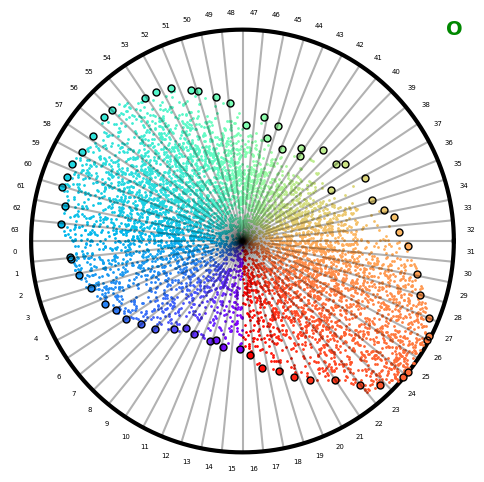

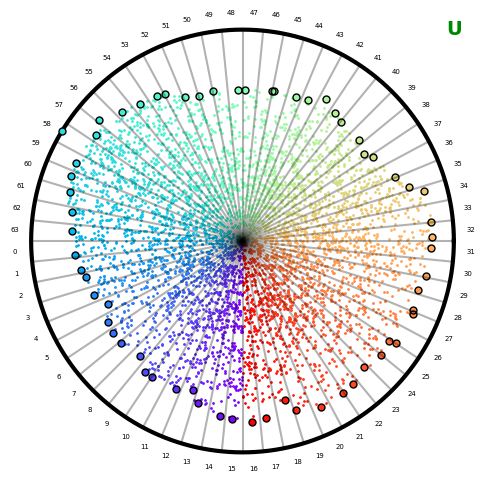

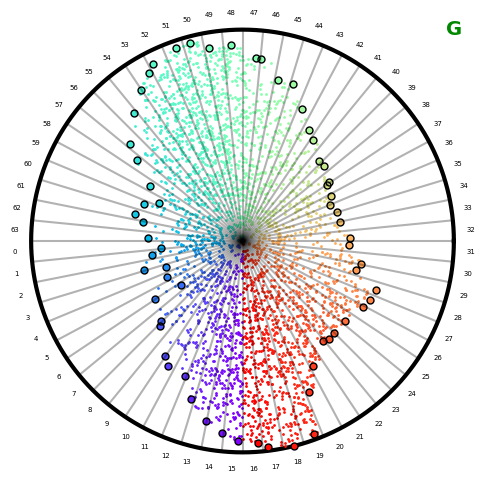

In [136]:
num_sectors = 64
State_dfs = {label_str:pdf.loc[pdf.label_str==label_str] for label_str in 'LBOUG'}
sect_dfs  = {label_str:sector_cut(labelled_data,num_sectors=num_sectors) for label_str,labelled_data in State_dfs.items() }
edge_df = pd.DataFrame()
for label_str,labelled_data in State_dfs.items():
    plt_sector(labelled_data,sect_dfs[label_str])

In [34]:
from matplotlib import rcParams,rc,font_manager
fonts = font_manager.findSystemFonts(fontpaths=['/packages/public/fonts'])
for font_file in fonts:
  font_manager.fontManager.addfont(font_file)
  font_manager.findfont("SF Mono")

rcParams.update({
  'xtick.top' : True,
  'ytick.right' : True,
  'figure.facecolor' : '#ffffff00',
  'figure.edgecolor' : '#000000ff',
  'figure.dpi'       : 300,
  'axes.linewidth'   : 1.75,
  'axes.edgecolor'   : '#000000ff',
  'axes.facecolor'   : '#ffffffff',
  'axes.labelsize'   : 16,
  'axes.titlesize'   : 16,
  'legend.fontsize'  : 16,
})


rc('font',**{'family':'monospace','monospace':['SF Mono'],'weight':500})
rc('mathtext',**{'fontset':'stixsans'})
rc('text',**{'usetex':False})

rc('pdf',fonttype=42)

findfont: Font family ['SF Mono'] not found. Falling back to DejaVu Sans.


In [91]:
def rplt(dfrow):
  path = dfrow.path
  lbl = path.split('/w')[-1].split('/')[0]
  ind = path.split('/')[-1].split('.')[0].split('-')[-1]
  D   = np.load(path)
  fig = plt.figure(figsize=np.array(D.shape)/100)
  ax  = plt.Axes(fig,[0,0,1,1])
  ax.set_axis_off()
  fig.clf()
  fig.add_axes(ax)
  for a in fig.axes:
    a.get_xaxis().set_visible(False)
    a.get_yaxis().set_visible(False)
  plt.imshow(D,cmap=plt.cm.Greys_r,origin='lower')
  plt.title(f"Exp. {lbl}, time index: {ind}",fontsize=8,weight='bold',color='#ddd')
#  ax = plt.gca()
  pcolor,lcolor = '#f0f', '#f0f'
  if 'preds' in dfrow:
    if dfrow.preds != dfrow.label:
      pcolor = '#f00'
      lcolor = '#0ff'
    ax.text(
      1.0,
      1.05,
      f'Prediction:{dfrow.preds_str}',
      size=8,
      color=pcolor,
      horizontalalignment='right',
      verticalalignment='bottom',
      transform=ax.transAxes,
      weight='bold',
    )
  ax.text(
    1.0,
    1.25,
    f'Class:{dfrow.label_str}',
    size=8,
    color=lcolor,
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=ax.transAxes,
    weight='bold',
  )
  ax.text(
    0.0,
    1.05,
    f'Regime:{dfrow.regime_str}',
    size=8,
    color='#f70',
    horizontalalignment='left',
    verticalalignment='bottom',
    transform=ax.transAxes,
    weight='bold',
  )


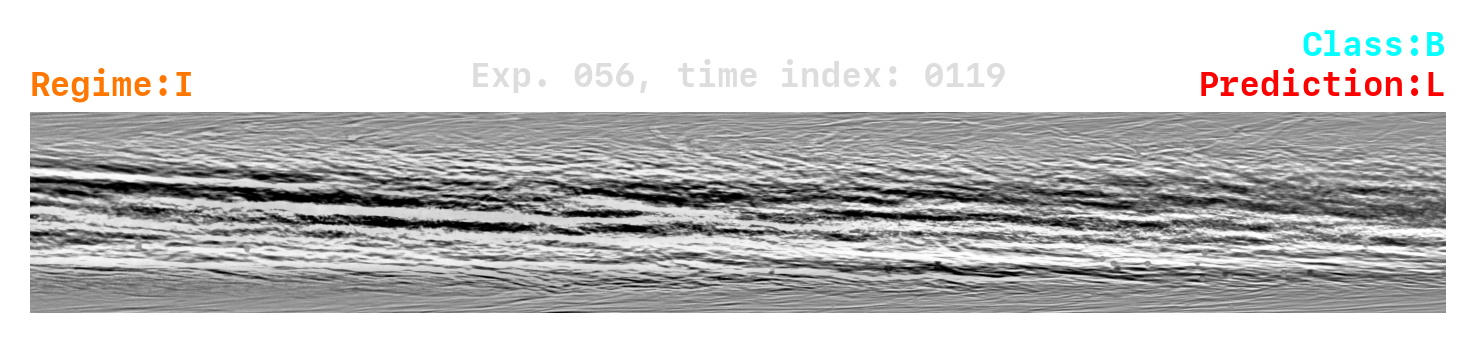

In [92]:
rplt(edf.iloc[50])

<img src="/scratch/jlbuzins/export/PCACNN-LABELS/experiment093/shadowgraph-0550.png" >

In [107]:
from IPython.display import Image


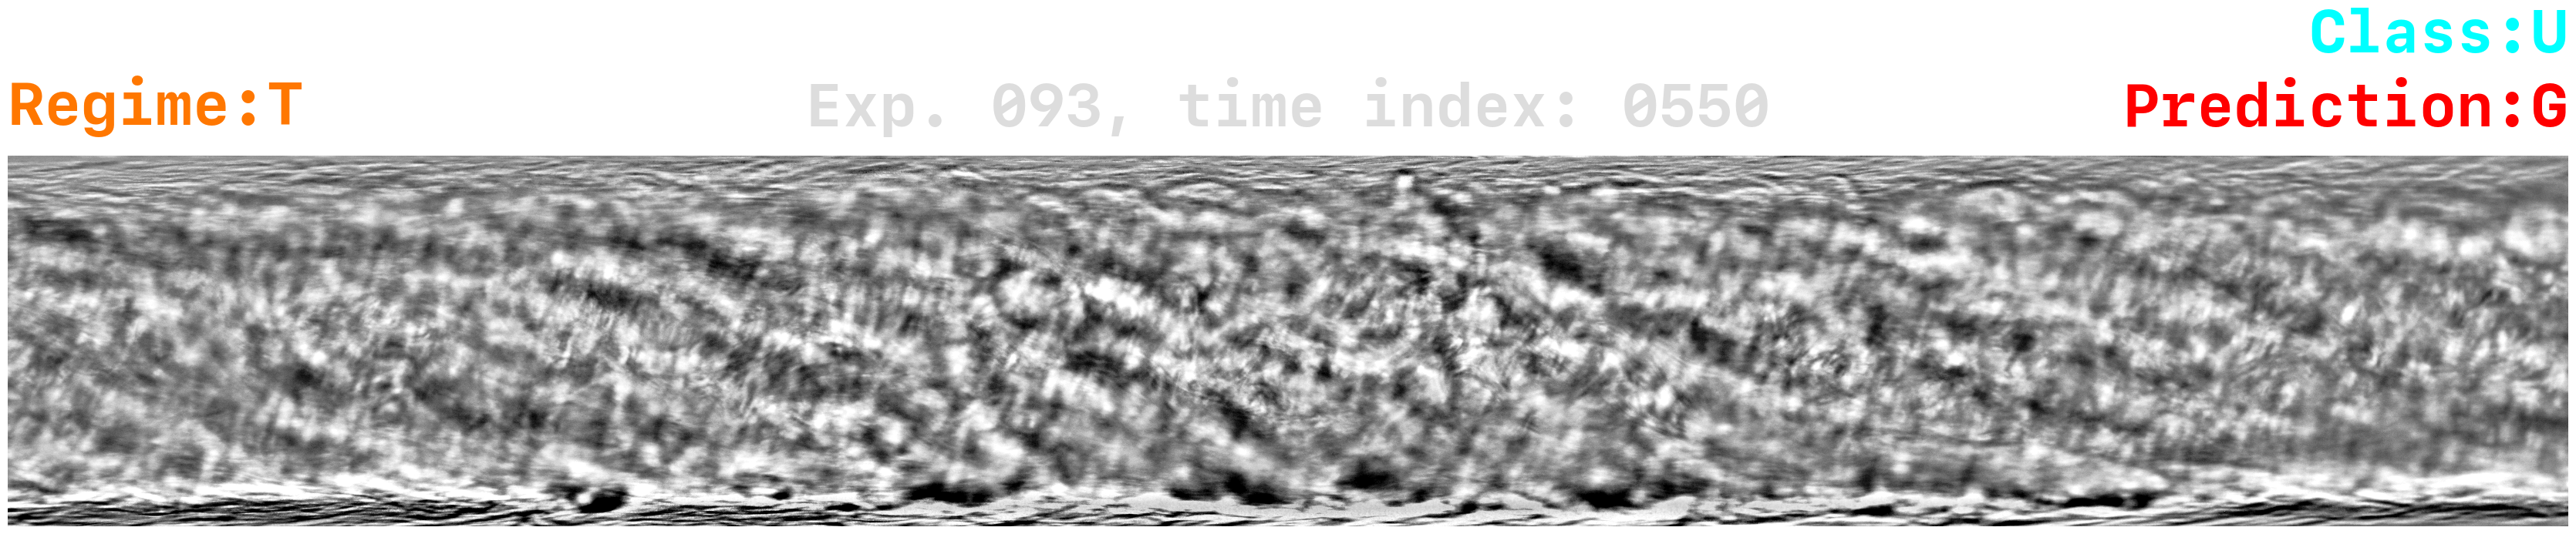

In [105]:
Image(filename='/scratch/jlbuzins/export/PCACNN-LABELS/experiment093/shadowgraph-0550.png')

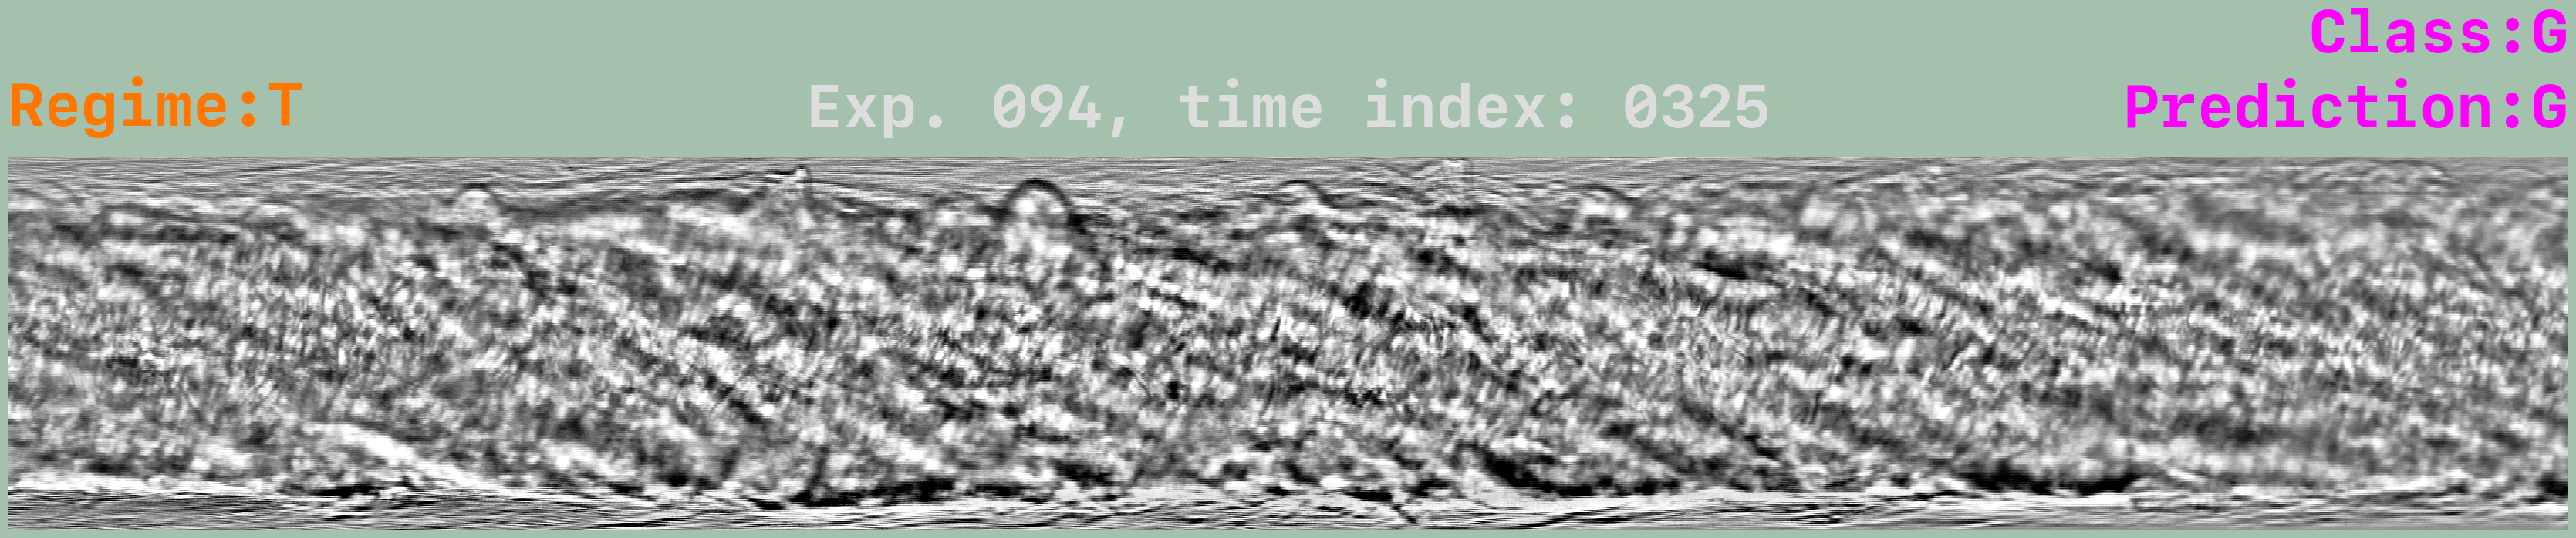

In [110]:
Image(filename='/scratch/jlbuzins/export/PCACNN-LABELS/experiment094/shadowgraph-0325.png')